In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

I want to find the best parameters for random forest model

In [ ]:
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [ ]:
class ModelDataHandler:

    def __init__(self, df_train, df_test):
        self.df_train = self.data_clean(df_train)
        self.df_test = self.data_clean(df_test)

    def data_clean(self, df):
        df.drop('Healthcare_1', axis=1, inplace=True)
        df.loc[df_train['LifeSquare'] > 1000, 'LifeSquare'] = df['LifeSquare'].median()
        df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
        df.drop('Id', axis=1, inplace=True)
        self.reduce_mem_df(df)
        return df

    def get_df(self):
        return self.df_train, self.df_test

    def reduce_mem_df(self, df):
        start_mem = df.memory_usage().sum() / 1024
        print(f'Memory usage start {start_mem} KB')

        for column in df.columns:
            col_type = df[column].dtype

            if col_type.kind != 'O':
                col_min = df[column].min()
                col_max = df[column].max()

                if df[column].dtype.kind == 'i':
                    for int_param in [np.int8, np.int16, np.int32]:
                        if col_min > np.iinfo(int_param).min and col_max < np.iinfo(int_param).max:
                            df[column] = df[column].astype(int_param)
                else:
                    for float_param in [np.float16, np.float32]:
                        if col_min > np.finfo(float_param).min and col_max < np.finfo(float_param).max:
                            df[column] = df[column].astype(float_param)
            else:
                df[column] = df[column].astype('category')

        end_mem = df.memory_usage().sum() / 1024
        print(f'memory after reduce {end_mem}')
        return df

my_model_handler = ModelDataHandler(df_train, df_test)
df_train, df_test = my_model_handler.get_df()

c:\users\user\desktop\data-science\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='LifeSquare'>

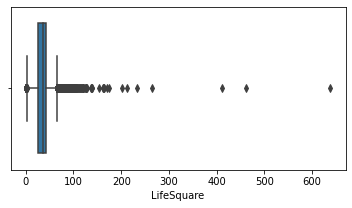

In [105]:
import  seaborn as sns

plt.figure(figsize=(6, 3))
sns.boxplot(df_train['LifeSquare'], whis=1.5)

In [ ]:
""" Drop column Healthcare_1 because it have 5743 not Nan"""
def drop_inplace(df):
    df.drop('Healthcare_1', axis=1, inplace=True)
    df.loc[df['LifeSquare'] > 1000, 'LifeSquare'] = df_train['LifeSquare'].median()
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())


drop_inplace(df_train)

In [5]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315613,36.255436,6.273300,8.526700,12.609400,3.990166e+03,0.118856,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839512,21.058096,18.004549,28.560917,5.241148,6.775974,2.005003e+05,0.119024,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.289062
min,0.00000,0.000000,0.000000,1.136719,0.370605,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.781250,25.523438,1.000000,4.000000,9.000000,1.974000e+03,0.017654,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.500000,36.255436,6.000000,7.000000,13.000000,1.977000e+03,0.075439,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.875000,41.437500,9.000000,12.000000,17.000000,2.001000e+03,0.195801,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.000000,638.000000,2014.000000,42.000000,117.000000,2.005201e+07,0.521973,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.437500


In [8]:
df_train.drop('Id', axis=1, inplace=True)

In [12]:
df_train = pd.get_dummies(df_train)

### 3 train test split

In [13]:
def split_data(df):
    x = df.drop('Price', axis=1)
    y = df['Price']
    return train_test_split(x, y, test_size=0.3, random_state=49)

x_train, x_valid, y_train, y_valid = split_data(df_train)

Random Forest

RobustScaler, MinMaxScaler, StandardScaler

In [19]:
def scale_data(df_train, df_valid, model):
    scaler_model = model
    df_train = scaler_model.fit_transform(df_train)
    df_valid = scaler_model.transform(df_valid)
    return df_train, df_valid

x_train, x_valid = scale_data(x_train, x_valid, RobustScaler())

In [22]:
class BuiltModelForest:
    def __init__(self, x_train, x_valid, y_train, y_valid):
        self.x_train = x_train
        self.x_valid = x_valid
        self.y_train = y_train
        self.y_valid = y_valid

    def fit(self):
        model = RandomForestRegressor(n_estimators=100, max_depth=9, max_features=16, random_state=49)
        self.model_learn  = model.fit(self.x_train, self.y_train)

    def predict(self):
        self.fit()
        self.y_pred_valid = self.model_learn.predict(self.x_valid)
        return self.y_pred_valid

    def metrics_score(self):
        return r2_score(self.y_valid, self.predict())

my_model = BuiltModelForest(x_train, x_valid, y_train, y_valid)
r2 = my_model.metrics_score()
print(r2)

0.727164474338994


In [23]:
y_pred_train = my_model.model_learn.predict(x_train)
r2_score(y_train, y_pred_train)

0.8190041816087099

In [28]:
x_train.shape
# my_model.model_learn.feature_importances_

(7000, 20)

In [31]:
parameters = [{'n_estimators': [50, 100, 150, 200],
               'max_features': np.arange(14, 18),
               'max_depth': np.arange(7, 12)}]
grid_forest = GridSearchCV(estimator=RandomForestRegressor(random_state=49),
                           param_grid=parameters,
                           scoring='r2',
                           cv=5)

grid_forest.fit(x_train, y_train)
y_pred_valid = grid_forest.predict(x_valid)

In [32]:
grid_forest.best_params_

{'max_depth': 11, 'max_features': 15, 'n_estimators': 200}

In [38]:
grid_forest.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [39]:
y_pred_train = grid_forest.predict(x_train)

In [40]:
r2_score(y_train, y_pred_train)

0.8774308006225957

### {'max_depth': 11, 'max_features': 15, 'n_estimators': 200}



In [42]:
df_test.describe()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [55]:
def dummies_df(df):
    df = pd.get_dummies(df)
    return df

df_train = dummies_df(df_train)
df_test = dummies_df(df_test)

In [57]:
def split_data(df):
    x = df.drop('Price', axis=1)
    y = df['Price']
    return train_test_split(x, y, test_size=0.3, random_state=49)

x_train, x_valid, y_train, y_valid = split_data(df_train)

In [58]:
def scale_data(df_train, df_valid, df_test, model):
    scaler_model = model
    df_train = scaler_model.fit_transform(df_train)
    df_valid = scaler_model.transform(df_valid)
    df_test = scaler_model.transform(df_test)
    return df_train, df_valid, df_test

x_train, x_valid, df_test = scale_data(x_train, x_valid, df_test, RobustScaler())


Built model random forest

In [65]:
class BuiltModelForest:
    def __init__(self, x_train, x_valid, y_train, y_valid):
        self.x_train = x_train
        self.x_valid = x_valid
        self.y_train = y_train
        self.y_valid = y_valid

    def fit(self):
        model = RandomForestRegressor(n_estimators=150, max_depth=9, max_features=15, random_state=49)
        self.model_learn  = model.fit(self.x_train, self.y_train)

    def predict(self):
        self.fit()
        self.y_pred_valid = self.model_learn.predict(self.x_valid)
        return self.y_pred_valid

    def metrics_score(self):
        return r2_score(self.y_valid, self.predict())

my_model = BuiltModelForest(x_train, x_valid, y_train, y_valid)
r2 = my_model.metrics_score()
print(r2)

0.727343495444118


In [66]:
y_pred_train = my_model.model_learn.predict(x_train)
r2_score(y_train, y_pred_train)

0.8179205629047268

In [67]:
y_pred_test = my_model.model_learn.predict(df_test)

In [71]:
df_id = pd.read_csv('datasets/sample_submission.csv')

In [72]:
df_id['Id']

0        4567
1        5925
2         960
3        3848
4         746
        ...  
4995    10379
4996    16138
4997     3912
4998     5722
4999    11004
Name: Id, Length: 5000, dtype: int64

In [99]:
y_pred_test = pd.DataFrame(y_pred_test, columns=['Price'])

,Price
0,159794.600838
1,123376.689514
2,153824.374127
3,135370.260455
4,209363.495061
...,...
4995,186290.607505
4996,385053.010105
4997,156800.231677
4998,189084.223271


In [100]:
df_finish = pd.concat([df_id['Id'], y_pred_test], axis=1)

In [101]:
df_finish

,Id,Price
0,4567,159794.600838
1,5925,123376.689514
2,960,153824.374127
3,3848,135370.260455
4,746,209363.495061
...,...,...
4995,10379,186290.607505
4996,16138,385053.010105
4997,3912,156800.231677
4998,5722,189084.223271


In [102]:
df_finish.to_csv('df_submit_1.csv', index=False)